# Inferential Statistics Ib - Frequentism

## Learning objectives

Welcome to the second Frequentist inference mini-project! Over the course of working on this mini-project and the previous frequentist mini-project, you'll learn the fundamental concepts associated with frequentist inference. The following list includes the topics you will become familiar with as you work through these two mini-projects:
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate confidence intervals and p-values
* how those confidence intervals and p-values allow you to perform hypothesis (or A/B) tests

## Prerequisites

* what a random variable is
* what a probability density function (pdf) is
* what the cumulative density function is
* a high-level sense of what the Normal distribution

If these concepts are new to you, please take a few moments to Google these topics in order to get a sense of what they are and how you might use them.

These two notebooks were designed to bridge the gap between having a basic understanding of probability and random variables and being able to apply these concepts in Python. This second frequentist inference mini-project focuses on a real-world application of this type of inference to give you further practice using these concepts. 

In the previous notebook, we used only data from a known normal distribution. You'll now tackle real data, rather than simulated data, and answer some relevant real-world business problems using the data.

## Hospital medical charges

Imagine that a hospital has hired you as their data analyst. An administrator is working on the hospital's business operations plan and needs you to help them answer some business questions. This mini-project, as well as the bootstrap and Bayesian inference mini-projects also found in this unit are designed to illustrate how each of the inferential statistics methods have their uses for different use cases. In this assignment notebook, you're going to use frequentist statistical inference on a data sample to answer the questions:
* has the hospital's revenue stream fallen below a key threshold?
* are patients with insurance really charged different amounts than those without?
Answering that last question with a frequentist approach makes some assumptions, or requires some knowledge, about the two groups. In the next mini-project, you'll use bootstrapping to test that assumption. And in the final mini-project of the unit, you're going to create a model for simulating _individual_ charges (not a sampling distribution) that the hospital can use to model a range of scenarios.

We are going to use some data on medical charges obtained from [Kaggle](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset). For the purposes of this exercise, assume the observations are the result of random sampling from our one hospital. Recall in the previous assignment, we introduced the Central Limit Theorem (CLT), and how it tells us that the distributions of sample statistics approach a normal distribution as $n$ increases. The amazing thing about this is that it applies to the sampling distributions of statistics that have been calculated from even highly non-normal distributions of data. Remember, also, that hypothesis testing is very much based on making inferences about such sample statistics. You're going to rely heavily on the CLT to apply frequentist (parametric) tests to answer the questions in this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from numpy.random import seed
medical = pd.read_csv('data/insurance2.csv')

In [2]:
medical.shape

(1338, 8)

In [3]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


__Q:__ Plot the histogram of charges and calculate the mean and standard deviation. Comment on the appropriateness of these statistics for the data.

__A:__ The asymmetric/one-sided shape of the distribution means that the standard deviation and mean aren't nearly as useful when compared to gaussian distributions. Specifically, the area underneath the curve is no longer symmetric w.r.t the mean.

In [4]:
# Mean, standard_deviation of charges
mc_mean, mc_std = medical.charges.mean(), medical.charges.std()
print('The mean is %f' % mc_mean)
print('The standard deviation is %f' % mc_std)

The mean is 13270.422265
The standard deviation is 12110.011237


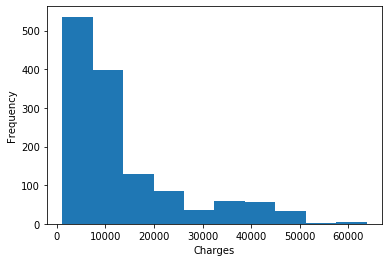

In [5]:
# Histogram of charges
medical.charges.plot.hist()
_ = plt.xlabel('Charges')
_ = plt.show()

In [6]:
# Approximate the area withing one standard deviation using numpy histogram binning. 
hist, bin_edges = np.histogram(medical.charges, density=True, bins=int(mc_mean//100))

# Indices where bin edges are within one standard deviation
leftstd_args =np.where((bin_edges<=mc_mean)&(bin_edges>=mc_mean-mc_std))
rightstd_args =  np.where((bin_edges>=mc_mean)&(bin_edges<=mc_mean+mc_std))

# sum the heights * widths for the area.
leftarea = np.sum(hist[leftstd_args]*np.diff(bin_edges)[leftstd_args])
rightarea = np.sum(hist[rightstd_args]*np.diff(bin_edges)[rightstd_args])

#print areas
print('The area (probability) to the left of the mean within one standard deviation is %f' % leftarea)
print('The area (probability) to the right of the mean within one standard deviation is %f' % rightarea)

The area (probability) to the left of the mean within one standard deviation is 0.674888
The area (probability) to the right of the mean within one standard deviation is 0.162182


__Q:__ The administrator is concerned that the actual average charge has fallen below 12000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed so far, to apply?

__A:__ I believe that the appeal is to the central limit theorem in this instance, because the number of samples is sufficiently large we can use this sample as a representation of the population. If that is true, then we can calculate and compare the sampling distribution of the mean and use the value 12000 to perform a t-test.

In [7]:
mean_sampling_dist = np.array([np.mean(np.random.choice(medical.charges, len(medical.charges))) for x in range(10000)])
mean_sampling_dist_mean = np.mean(mean_sampling_dist)
mean_sampling_dist_std = np.std(mean_sampling_dist)
t.sf(12000, len(mean_sampling_dist), loc=mean_sampling_dist_mean, scale=mean_sampling_dist_std)

0.9999348101329796

__Q:__ Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A one-sided or two-sided interval? Calculate the critical value and the relevant 95% confidence interval for the mean and comment on whether the administrator should be concerned?

__A:__ One sided because we only care whether the average charge is greater than 12000. The administrator should likely not be concerned based on the fact that the confidence interval does not include the value 12000.

In [8]:
critical_value = t.ppf(0.05, len(mean_sampling_dist), scale=mean_sampling_dist_std, loc=mean_sampling_dist_mean)
print('The critical value for the one sided 95% confidence interval is ', critical_value)

The critical value for the one sided 95% confidence interval is  12722.446760950554


The administrator then wants to know whether people with insurance really are charged a different amount to those without.

__Q:__ State the null and alternative hypothesis here. Use the _t_-test for the difference between means where the pooled standard deviation of the two groups is given by
\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

and the *t* test statistic is then given by

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

What assumption about the variances of the two groups are we making here?

__A:__ 

The hypothesis set is then
\begin{array}{lcr}
H_0:\mu_0 &=& \mu_1 \\
H_1:\mu_0 &\neq& \mu_1 \\
\end{array}

and the main assumption is that the two groups have equal variances

__Q:__ Perform this hypothesis test both manually, using the above formulae, and then using the appropriate function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) (hint, you're looking for a function to perform a _t_-test on two independent samples). For the manual approach, calculate the value of the test statistic and then its probability (the p-value). Verify you get the same results from both.

__A:__ 

In [9]:
# Compute the pooled variance and t statistic manually
charges_no_insurance =  medical[medical.insuranceclaim == 0].charges.values
charges_insurance = medical[medical.insuranceclaim == 1].charges.values
s0, s1 = np.std(charges_no_insurance), np.std(charges_insurance)
n0, n1 = len(charges_no_insurance), len(charges_insurance)

sp = np.sqrt( ((n0-1)*s0**2 + (n1-1)*s1**2) / (n0 + n1 - 2))
tstat = (np.mean(charges_insurance) - np.mean(charges_no_insurance)) / (sp * np.sqrt( (1/n0) + (1/n1) ))
print('T statistic value using manual calculation: %f' %  tstat)

T statistic value using manual calculation: 11.901307


In [10]:
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_rel
ttest_ind_t, ttest_ind_pvalue = ttest_ind(charges_insurance, charges_no_insurance)
print('T statistic value using SciPy ttest_ind: %f' %  ttest_ind_t)

T statistic value using SciPy ttest_ind: 11.893299


The probability of the test statistic for ttest_ind result is given:

In [11]:
print('p-value using SciPy ttest_ind: %f' %  ttest_ind_pvalue)
manual_p_value = t.sf(tstat, n0+n1-2)
print('p-value manually: %f' %  manual_p_value)

p-value using SciPy ttest_ind: 0.000000
p-value manually: 0.000000


Congratulations! Hopefully you got the exact same numerical results. This shows that you correctly calculated the numbers by hand. Secondly, you used the correct function and saw that it's much easier to use. All you need to do pass your data to it.

__Q:__ In the above calculations, we assumed the sample variances were equal. We may well suspect they are not (we'll explore this in another assignment). The calculation becomes a little more complicated to do by hand in this case, but we now know of a helpful function. Check the documentation for the function to tell it not to assume equal variances and perform the test again.

__A:__

In [13]:
ttest_ind_t_neq, ttest_ind_pvalue_neq = ttest_ind(charges_insurance,charges_no_insurance ,equal_var=False)
print('T statistic value assuming unequal variances: %f' %  ttest_ind_pvalue_neq)

T statistic value using SciPy ttest_ind: 0.000000


__Q:__ Conceptual question: look through the documentation for statistical test functions in scipy.stats. You'll see the above _t_-test for a sample, but can you see an equivalent one for performing a *z*-test from a sample? Comment on your answer.

__A:__ The closest thing I see is scipy.stats.zscore, which calculates the zscore for each value in the sample provided relative to the sample mean and standard deviation. The alternative would be to use the cdf or survival function of the distribution itself.

## Learning outcomes

Having completed this project notebook, you now have good hands-on experience:
* using the central limit theorem to help you apply frequentist techniques to answer questions that pertain to very non-normally distributed data from the real world
* performing inference using such data to answer business questions
* forming a hypothesis and framing the null and alternative hypotheses
* testing this using a _t_-test